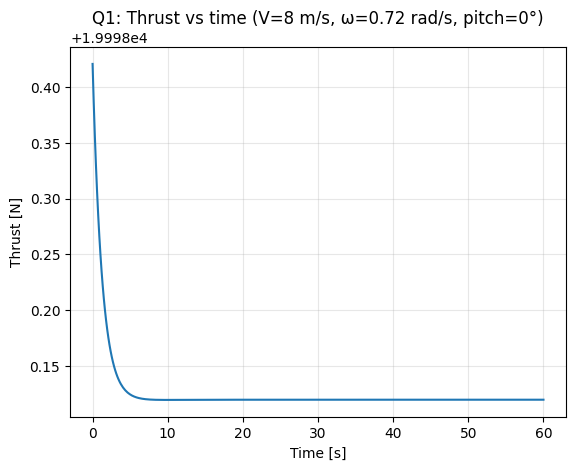

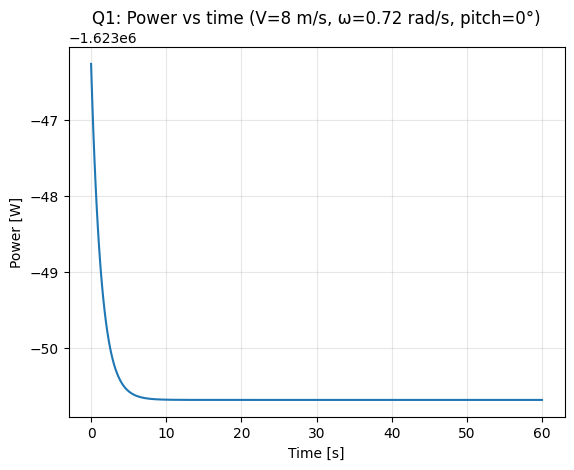

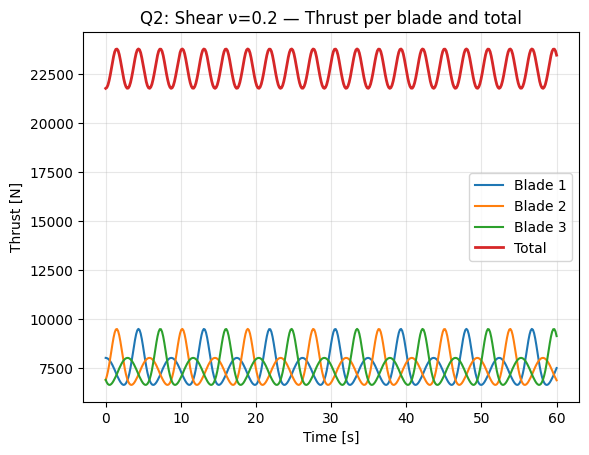

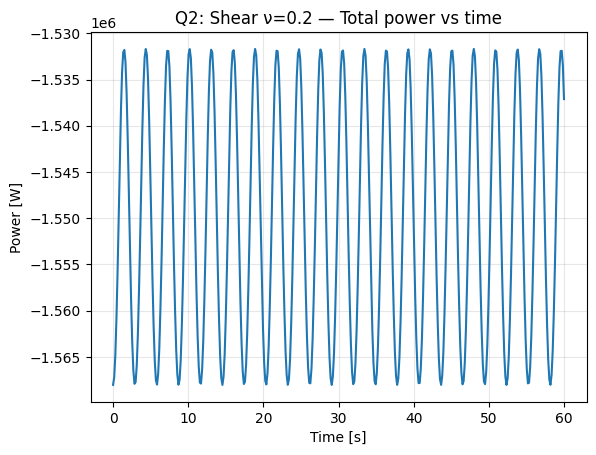

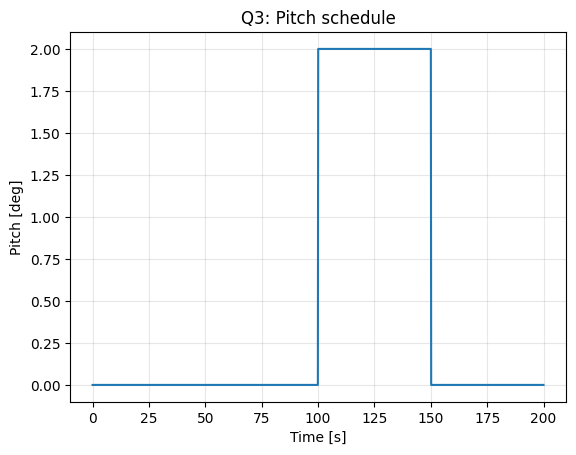

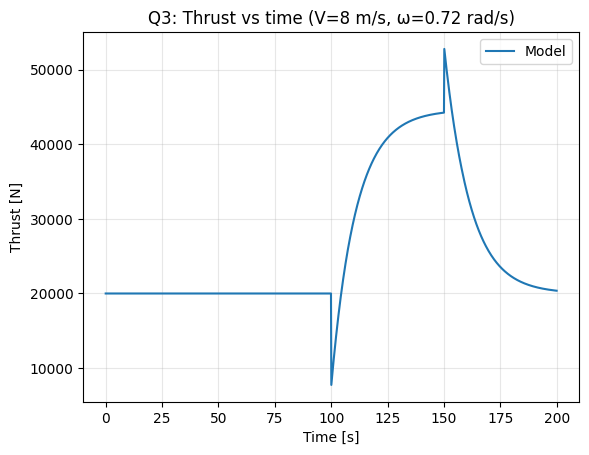

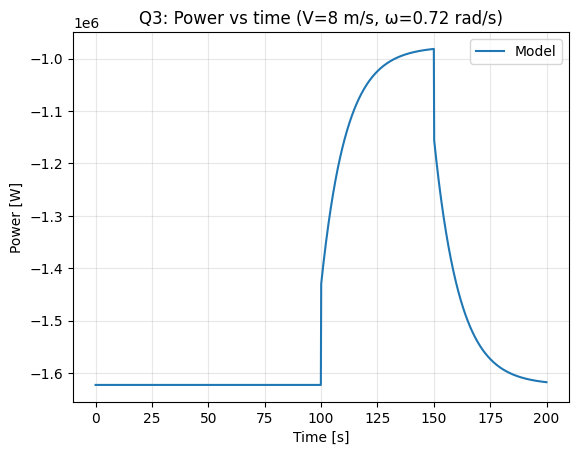

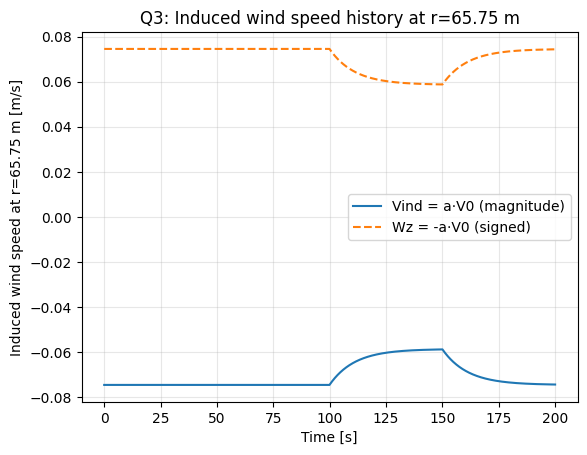

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

# =========================
# Assignment 1 – Q1 + Q2 + Q3
# uBEM-ready framework, loads computed like your TASK 4:
#   iterate a/ap -> Vrel -> L,D -> fN,fT
# =========================

# -------- Files (keep in same folder as this script) --------
DATA_DIR = "."
BLADE_FILE = os.path.join(DATA_DIR, "bladedat.txt")

AIRFOIL_FILES = {
    100.0: os.path.join(DATA_DIR, "cylinder_ds.txt"),
    24.1:  os.path.join(DATA_DIR, "FFA-W3-241_ds.txt"),
    30.1:  os.path.join(DATA_DIR, "FFA-W3-301_ds.txt"),
    36.0:  os.path.join(DATA_DIR, "FFA-W3-360_ds.txt"),
    48.0:  os.path.join(DATA_DIR, "FFA-W3-480_ds.txt"),
    60.0:  os.path.join(DATA_DIR, "FFA-W3-600_ds.txt"),
}

# -------- Turbine / case constants --------
R = 89.17
B = 3
rho = 1.225

# Operating point (assignment)
omega = 0.72
Vhub = 8.0

# Time
dt = 0.15
T_end_Q1Q2 = 60.0
T_end_Q3 = 200.0

# Discretization
Nsec = 40

# Q2 shear parameters
H_HUB = 119.0
SHEAR_EXP = 0.2

# Solver params (like your TASK 4)
F_RELAX = 0.10
TOL_RES = 1e-6
ITMAX = 1000

# Q3 dynamic inflow ON (needed for meaningful induction history)
USE_DYNAMIC_INFLOW_Q3 = True
TAU_Q3 = R / max(Vhub, 0.1)  # ~11 s at 8 m/s (tune if needed)

# Warm start (recommended): avoids huge transient at t=0
WARM_START = True


# =========================
# Recorder
# =========================
@dataclass
class Recorder:
    t: list = field(default_factory=list)
    T_blades: list = field(default_factory=list)
    P_blades: list = field(default_factory=list)
    T_total: list = field(default_factory=list)
    P_total: list = field(default_factory=list)

    # optional (Q3)
    pitch_deg: list = field(default_factory=list)
    a_probe: list = field(default_factory=list)
    Vind_probe: list = field(default_factory=list)   # magnitude a*Vhub
    Wz_probe: list = field(default_factory=list)     # signed induced axial velocity = -a*Vhub

    def record(self, t, T_blades, P_blades, T_total, P_total,
               pitch_deg=np.nan, a_probe=np.nan, Vind_probe=np.nan, Wz_probe=np.nan):
        self.t.append(t)
        self.T_blades.append(np.array(T_blades, dtype=float))
        self.P_blades.append(np.array(P_blades, dtype=float))
        self.T_total.append(T_total)
        self.P_total.append(P_total)

        self.pitch_deg.append(pitch_deg)
        self.a_probe.append(a_probe)
        self.Vind_probe.append(Vind_probe)
        self.Wz_probe.append(Wz_probe)

    def as_arrays(self):
        return {
            "t": np.array(self.t, dtype=float),
            "T_blades": np.vstack(self.T_blades) if self.T_blades else np.zeros((0, 0)),
            "P_blades": np.vstack(self.P_blades) if self.P_blades else np.zeros((0, 0)),
            "T_total": np.array(self.T_total, dtype=float),
            "P_total": np.array(self.P_total, dtype=float),
            "pitch_deg": np.array(self.pitch_deg, dtype=float),
            "a_probe": np.array(self.a_probe, dtype=float),
            "Vind_probe": np.array(self.Vind_probe, dtype=float),
            "Wz_probe": np.array(self.Wz_probe, dtype=float),
        }


# =========================
# 1) Read blade geometry + build sections
# =========================
def read_bladedat(path):
    """
    MATCHING YOUR STEADY BEM ASSUMPTION:
      col0: r [m]
      col1: c [m]
      col2: beta [deg]
      col3: t/c [%]   (or ratio)
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing blade file: {path}")

    data = np.loadtxt(path)
    if data.ndim != 2 or data.shape[1] < 4:
        raise ValueError("bladedat.txt must have >= 4 columns")

    r = data[:, 0]
    c = data[:, 1]
    beta_deg = data[:, 2]
    tc = data[:, 3]

    if np.nanmax(tc) <= 1.5:
        tc = tc * 100.0

    idx = np.argsort(r)
    return r[idx], c[idx], beta_deg[idx], tc[idx]


def build_sections(r_tab, c_tab, beta_deg_tab, tc_tab, nsec):
    r0 = float(np.min(r_tab))
    Rtip = float(np.max(r_tab))
    r_sec = np.linspace(r0, 0.98 * Rtip, nsec)

    c_sec = np.interp(r_sec, r_tab, c_tab)
    beta_deg_sec = np.interp(r_sec, r_tab, beta_deg_tab)
    tc_sec = np.interp(r_sec, r_tab, tc_tab)
    return Rtip, r_sec, c_sec, beta_deg_sec, tc_sec


# =========================
# 2) Read polars + interpolation with extrapolation
# =========================
def read_polar_file(path):
    tbl = np.loadtxt(path, ndmin=2)
    if tbl.shape[1] < 3:
        raise ValueError(f"{path} must have >= 3 columns: alpha, Cl, Cd")
    alpha = tbl[:, 0]
    cl = tbl[:, 1]
    cd = tbl[:, 2]
    order = np.argsort(alpha)
    return alpha[order], cl[order], cd[order]


def load_airfoils(files_dict):
    items = sorted(files_dict.items(), key=lambda kv: kv[0])  # by tc%
    thick = np.array([tc for tc, _ in items], dtype=float)

    aoa_cols, cl_cols, cd_cols = [], [], []
    for tc, fname in items:
        if not os.path.exists(fname):
            raise FileNotFoundError(f"Missing airfoil file: {fname}")
        a, cl, cd = read_polar_file(fname)
        aoa_cols.append(a)
        cl_cols.append(cl)
        cd_cols.append(cd)
    return thick, aoa_cols, cl_cols, cd_cols


THICK, AOA_COLS, CL_COLS, CD_COLS = load_airfoils(AIRFOIL_FILES)


def interp_extrap(x, xp, yp):
    x = float(x)
    xp = np.asarray(xp, dtype=float)
    yp = np.asarray(yp, dtype=float)

    if x <= xp[0]:
        x0, x1 = xp[0], xp[1]
        y0, y1 = yp[0], yp[1]
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
    if x >= xp[-1]:
        x0, x1 = xp[-2], xp[-1]
        y0, y1 = yp[-2], yp[-1]
        return y1 + (y1 - y0) * (x - x1) / (x1 - x0)
    return float(np.interp(x, xp, yp))


def cl_cd_double_interp(alpha_deg, tc_percent):
    tc = float(np.clip(tc_percent, THICK.min(), THICK.max()))
    cl_thk = np.empty(len(THICK))
    cd_thk = np.empty(len(THICK))

    for k in range(len(THICK)):
        cl_thk[k] = interp_extrap(alpha_deg, AOA_COLS[k], CL_COLS[k])
        cd_thk[k] = interp_extrap(alpha_deg, AOA_COLS[k], CD_COLS[k])

    cl = float(np.interp(tc, THICK, cl_thk))
    cd = float(np.interp(tc, THICK, cd_thk))
    return cl, cd


# =========================
# 3) Prandtl tip loss
# =========================
def prandtl_tip_loss(B, r, R, phi):
    sphi = abs(np.sin(phi))
    sphi = max(sphi, 1e-12)
    ftip = (B * (R - r)) / (2.0 * r * sphi)
    ftip = max(0.0, ftip)
    F = (2.0 / np.pi) * np.arccos(np.exp(-ftip))
    return float(np.clip(F, 1e-6, 1.0))


# =========================
# 4) Quasi-steady solve a/ap (TASK-4-style)
# =========================
def solve_a_ap_qs(V0, Omega, r, chord, twist_deg, pitch_deg, tc_percent, a_init, ap_init):
    theta_p = np.deg2rad(pitch_deg)
    twist = np.deg2rad(twist_deg)

    a = a_init
    ap = ap_init

    a_new = 0.10 if a_init == 0.0 else a_init
    ap_new = 0.00 if ap_init == 0.0 else ap_init

    it = 0
    while True:
        it += 1
        a, ap = a_new, ap_new

        denom = (1.0 + ap) * Omega * r + 1e-12
        phi = np.arctan(((1.0 - a) * V0) / denom)
        alpha_deg = np.rad2deg(phi - (twist + theta_p))

        Cl, Cd = cl_cd_double_interp(alpha_deg, tc_percent)

        Cn = Cl * np.cos(phi) + Cd * np.sin(phi)
        Ct = Cl * np.sin(phi) - Cd * np.cos(phi)

        sigma = (B * chord) / (2.0 * np.pi * r + 1e-12)
        F = prandtl_tip_loss(B, r, R, phi)

        sphi = np.sin(phi)
        cphi = np.cos(phi)

        a_fix  = (sigma * Cn * (1.0 - a)) / (4.0 * F * (sphi ** 2) + 1e-12)
        ap_fix = (sigma * Ct * (1.0 + ap)) / (4.0 * F * sphi * cphi + 1e-12)

        if a > 0.33:
            dCT = ((1.0 - a) ** 2 * Cn * sigma) / (sphi ** 2 + 1e-12)
            a_fix = dCT / (4.0 * F * (1.0 - 0.25 * (5.0 - 3.0 * a) * a) + 1e-12)

        a_new  = a  + F_RELAX * (a_fix  - a)
        ap_new = ap + F_RELAX * (ap_fix - ap)

        if max(abs(a_fix - a), abs(ap_fix - ap)) < TOL_RES or it >= ITMAX:
            return a_new, ap_new


# =========================
# 5) Loads from a/ap (TASK-4-style projection using L and D)
# =========================
def loads_from_a_ap(V0, Omega, r, chord, twist_deg, pitch_deg, tc_percent, a, ap):
    theta_p = np.deg2rad(pitch_deg)
    twist = np.deg2rad(twist_deg)

    denom = (1.0 + ap) * Omega * r + 1e-12
    phi = np.arctan(((1.0 - a) * V0) / denom)
    alpha_deg = np.rad2deg(phi - (twist + theta_p))

    Cl, Cd = cl_cd_double_interp(alpha_deg, tc_percent)

    Vrel = np.sqrt(((1.0 - a) * V0) ** 2 + ((1.0 + ap) * Omega * r) ** 2)
    L = 0.5 * rho * Vrel ** 2 * chord * Cl
    D = 0.5 * rho * Vrel ** 2 * chord * Cd

    fT = L * np.sin(phi) - D * np.cos(phi)
    fN = L * np.cos(phi) + D * np.sin(phi)
    return fN, fT


# =========================
# 6) Wind models
# =========================
def wind_constant(r_sec, Vhub):
    return np.full_like(r_sec, Vhub, dtype=float)


def wind_shear(r_sec, Vhub, H, nu, azimuth):
    z = H + r_sec * np.cos(azimuth)
    z = np.maximum(z, 1e-3)
    return Vhub * (z / H) ** nu


# =========================
# 7) Pitch schedule for Q3
# =========================
def pitch_schedule_deg(t):
    if t < 100.0:
        return 0.0
    if t <= 150.0:
        return 2.0
    return 0.0


# =========================
# 8) Warm start induction (avoid huge initial transient)
# =========================
def warm_start_induction(a_state, ap_state, r_sec, c_sec, beta_deg_sec, tc_sec, Vz_local, pitch_deg):
    for j in range(len(r_sec)):
        a_state[j], ap_state[j] = solve_a_ap_qs(
            Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], pitch_deg, tc_sec[j],
            a_state[j], ap_state[j]
        )


# =========================
# 9) Q1 simulation (constant wind, constant pitch)
# =========================
def run_Q1(r_sec, c_sec, beta_deg_sec, tc_sec):
    n_steps = int(np.floor(T_end_Q1Q2 / dt)) + 1

    a_state = np.zeros(len(r_sec))
    ap_state = np.zeros(len(r_sec))

    Vz_local = wind_constant(r_sec, Vhub)

    if WARM_START:
        warm_start_induction(a_state, ap_state, r_sec, c_sec, beta_deg_sec, tc_sec, Vz_local, pitch_deg=0.0)

    rec = Recorder()
    fN_last = np.zeros(len(r_sec))
    fT_last = np.zeros(len(r_sec))

    for k in range(n_steps):
        t = k * dt

        fN = np.zeros_like(r_sec)
        fT = np.zeros_like(r_sec)

        for j in range(len(r_sec)):
            a_qs, ap_qs = solve_a_ap_qs(
                Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], 0.0, tc_sec[j],
                a_state[j], ap_state[j]
            )
            a_state[j], ap_state[j] = a_qs, ap_qs
            fN[j], fT[j] = loads_from_a_ap(
                Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], 0.0, tc_sec[j],
                a_state[j], ap_state[j]
            )

        Tblade = np.trapezoid(fN, r_sec)
        Qblade = np.trapezoid(fT * r_sec, r_sec)
        Pblade = omega * Qblade

        Ttot = B * Tblade
        Ptot = B * Pblade

        rec.record(t, [Tblade], [Pblade], Ttot, Ptot)
        fN_last[:] = fN
        fT_last[:] = fT

    out = rec.as_arrays()
    out["fN_last"] = fN_last
    out["fT_last"] = fT_last
    return out


# =========================
# 10) Q2 simulation (shear, 3 blades)
# =========================
def run_Q2(r_sec, c_sec, beta_deg_sec, tc_sec):
    n_steps = int(np.floor(T_end_Q1Q2 / dt)) + 1

    a_state = np.zeros((B, len(r_sec)))
    ap_state = np.zeros((B, len(r_sec)))

    # warm start at t=0 for each blade azimuth
    if WARM_START:
        for b in range(B):
            azim0 = 0.0 + 2.0 * np.pi * b / B
            Vz_local = wind_shear(r_sec, Vhub, H_HUB, SHEAR_EXP, azim0)
            warm_start_induction(a_state[b], ap_state[b], r_sec, c_sec, beta_deg_sec, tc_sec, Vz_local, pitch_deg=0.0)

    rec = Recorder()

    for k in range(n_steps):
        t = k * dt

        T_b = np.zeros(B)
        P_b = np.zeros(B)

        for b in range(B):
            azim = omega * t + 2.0 * np.pi * b / B
            Vz_local = wind_shear(r_sec, Vhub, H_HUB, SHEAR_EXP, azim)

            fN = np.zeros_like(r_sec)
            fT = np.zeros_like(r_sec)

            for j in range(len(r_sec)):
                a_qs, ap_qs = solve_a_ap_qs(
                    Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], 0.0, tc_sec[j],
                    a_state[b, j], ap_state[b, j]
                )
                a_state[b, j], ap_state[b, j] = a_qs, ap_qs
                fN[j], fT[j] = loads_from_a_ap(
                    Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], 0.0, tc_sec[j],
                    a_state[b, j], ap_state[b, j]
                )

            T_b[b] = np.trapezoid(fN, r_sec)
            Qblade = np.trapezoid(fT * r_sec, r_sec)
            P_b[b] = omega * Qblade

        Ttot = np.sum(T_b)
        Ptot = np.sum(P_b)
        rec.record(t, T_b, P_b, Ttot, Ptot)

    return rec.as_arrays()


# =========================
# 11) Q3 simulation (pitch step + induction history at r=65.75)
# =========================
def run_Q3(r_sec, c_sec, beta_deg_sec, tc_sec, r_probe=65.75):
    n_steps = int(np.floor(T_end_Q3 / dt)) + 1

    a_state = np.zeros(len(r_sec))
    ap_state = np.zeros(len(r_sec))

    Vz_local = wind_constant(r_sec, Vhub)

    # warm start at pitch=0
    if WARM_START:
        warm_start_induction(a_state, ap_state, r_sec, c_sec, beta_deg_sec, tc_sec, Vz_local, pitch_deg=0.0)

    rec = Recorder()

    for k in range(n_steps):
        t = k * dt
        pitch = pitch_schedule_deg(t)

        fN = np.zeros_like(r_sec)
        fT = np.zeros_like(r_sec)

        for j in range(len(r_sec)):
            a_qs, ap_qs = solve_a_ap_qs(
                Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], pitch, tc_sec[j],
                a_state[j], ap_state[j]
            )

            if USE_DYNAMIC_INFLOW_Q3:
                fac = dt / max(TAU_Q3, 1e-6)
                fac = np.clip(fac, 0.0, 1.0)
                a_state[j]  = a_state[j]  + fac * (a_qs  - a_state[j])
                ap_state[j] = ap_state[j] + fac * (ap_qs - ap_state[j])
            else:
                a_state[j], ap_state[j] = a_qs, ap_qs

            fN[j], fT[j] = loads_from_a_ap(
                Vz_local[j], omega, r_sec[j], c_sec[j], beta_deg_sec[j], pitch, tc_sec[j],
                a_state[j], ap_state[j]
            )

        Tblade = np.trapezoid(fN, r_sec)
        Qblade = np.trapezoid(fT * r_sec, r_sec)
        Pblade = omega * Qblade

        Ttot = B * Tblade
        Ptot = B * Pblade

        # probe induction at r=65.75
        a_p = np.interp(r_probe, r_sec, a_state)
        Vind_mag = a_p * Vhub
        Wz_signed = -a_p * Vhub

        rec.record(t, [Tblade], [Pblade], Ttot, Ptot,
                   pitch_deg=pitch, a_probe=a_p, Vind_probe=Vind_mag, Wz_probe=Wz_signed)

    return rec.as_arrays()


# =========================
# 12) Plot helpers
# =========================
def plot_Q1(out1):
    plt.figure()
    plt.plot(out1["t"], out1["T_total"])
    plt.xlabel("Time [s]")
    plt.ylabel("Thrust [N]")
    plt.title("Q1: Thrust vs time (V=8 m/s, ω=0.72 rad/s, pitch=0°)")
    plt.grid(True, alpha=0.3)

    plt.figure()
    plt.plot(out1["t"], out1["P_total"])
    plt.xlabel("Time [s]")
    plt.ylabel("Power [W]")
    plt.title("Q1: Power vs time (V=8 m/s, ω=0.72 rad/s, pitch=0°)")
    plt.grid(True, alpha=0.3)


def plot_Q2(out2):
    plt.figure()
    for b in range(out2["T_blades"].shape[1]):
        plt.plot(out2["t"], out2["T_blades"][:, b], label=f"Blade {b+1}")
    plt.plot(out2["t"], out2["T_total"], lw=2, label="Total")
    plt.xlabel("Time [s]")
    plt.ylabel("Thrust [N]")
    plt.title("Q2: Shear ν=0.2 — Thrust per blade and total")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.figure()
    plt.plot(out2["t"], out2["P_total"])
    plt.xlabel("Time [s]")
    plt.ylabel("Power [W]")
    plt.title("Q2: Shear ν=0.2 — Total power vs time")
    plt.grid(True, alpha=0.3)


def plot_Q3(out3):
    plt.figure()
    plt.plot(out3["t"], out3["pitch_deg"])
    plt.xlabel("Time [s]")
    plt.ylabel("Pitch [deg]")
    plt.title("Q3: Pitch schedule")
    plt.grid(True, alpha=0.3)

    plt.figure()
    plt.plot(out3["t"], out3["T_total"], label="Model")
    plt.xlabel("Time [s]")
    plt.ylabel("Thrust [N]")
    plt.title("Q3: Thrust vs time (V=8 m/s, ω=0.72 rad/s)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.figure()
    plt.plot(out3["t"], out3["P_total"], label="Model")
    plt.xlabel("Time [s]")
    plt.ylabel("Power [W]")
    plt.title("Q3: Power vs time (V=8 m/s, ω=0.72 rad/s)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.figure()
    plt.plot(out3["t"], out3["Vind_probe"], label="Vind = a·V0 (magnitude)")
    plt.plot(out3["t"], out3["Wz_probe"], "--", label="Wz = -a·V0 (signed)")
    plt.xlabel("Time [s]")
    plt.ylabel("Induced wind speed at r=65.75 m [m/s]")
    plt.title("Q3: Induced wind speed history at r=65.75 m")
    plt.grid(True, alpha=0.3)
    plt.legend()


# =========================
# 13) Main
# =========================
def main():
    r_tab, c_tab, beta_deg_tab, tc_tab = read_bladedat(BLADE_FILE)
    _, r_sec, c_sec, beta_deg_sec, tc_sec = build_sections(r_tab, c_tab, beta_deg_tab, tc_tab, Nsec)

    out1 = run_Q1(r_sec, c_sec, beta_deg_sec, tc_sec)
    out2 = run_Q2(r_sec, c_sec, beta_deg_sec, tc_sec)
    out3 = run_Q3(r_sec, c_sec, beta_deg_sec, tc_sec, r_probe=65.75)

    plot_Q1(out1)
    plot_Q2(out2)
    plot_Q3(out3)

    plt.show()


if __name__ == "__main__":
    main()